# Forest Cover Prediction (notebook 1)


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [28]:
import pandas as pd
from pathlib import Path

# path Path to have a ls method
Path.ls = lambda x: list(x.iterdir())

In [15]:
p = Path('/data/ifu/summerschool/original.datasets')
p.ls()

[PosixPath('/data/ifu/summerschool/original.datasets/kaggle.planet-amazon'),
 PosixPath('/data/ifu/summerschool/original.datasets/ImageCLEF_2012'),
 PosixPath('/data/ifu/summerschool/original.datasets/ImageCLEF_2013'),
 PosixPath('/data/ifu/summerschool/original.datasets/ifu.polz'),
 PosixPath('/data/ifu/summerschool/original.datasets/PlantCLEF_2017'),
 PosixPath('/data/ifu/summerschool/original.datasets/PlantCLEF_2014')]

## Fetching and processing the data

The dataset is located at the [UCI machine learning data repository](https://archive.ics.uci.edu/ml/datasets/covertype). If you visit the site you can copy the download links and read about the dataset.  
We pull the gzipped data and the metadata file and uncompress it using bash commands.

In [34]:
# download the file and metadata (using bash)
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.info    
! gzip -d covtype.data.gz

--2019-08-06 09:30:06--  https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11240707 (11M) [application/x-httpd-php]
Saving to: ‘covtype.data.gz’

covtype.data.gz     100%[===================>]  10.72M  5.95MB/s    in 1.8s    

2019-08-06 09:30:09 (5.95 MB/s) - ‘covtype.data.gz’ saved [11240707/11240707]

--2019-08-06 09:30:09--  https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.info
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14610 (14K) [application/x-httpd-php]
Saving to: ‘covtype.info.1’

covtype.info.1      100%[===================>]  14.27K  87.8K

In [295]:
# lets inspect the data
! head -n 3 covtype.data

2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


As you can see we do not get any information about the columns/ features contained. You can read details about the data in the covtype.info file (section 7). However, the gist of it is also given on the data webpage.

The feature columns are:

| Name | Data Type | Measurement | Description |
|---|---|---|---|
|Elevation | quantitative |meters | Elevation in meters |
|Aspect | quantitative | azimuth | Aspect in degrees azimuth | 
|Slope | quantitative | degrees | Slope in degrees  |
|Horizontal_Distance_To_Hydrology | quantitative | meters | Horz Dist to nearest surface water features | 
|Vertical_Distance_To_Hydrology | quantitative | meters | Vert Dist to nearest surface water features | 
|Horizontal_Distance_To_Roadways | quantitative | meters | Horz Dist to nearest roadway |
|Hillshade_9am | quantitative | 0 to 255 index | Hillshade index at 9am, summer solstice |
|Hillshade_Noon | quantitative | 0 to 255 index | Hillshade index at noon, summer soltice |
|Hillshade_3pm | quantitative | 0 to 255 index | Hillshade index at 3pm, summer solstice |
|Horizontal_Distance_To_Fire_Points | quantitative | meters | Horz Dist to nearest wildfire ignition points |
|Wilderness_Area (4 binary columns) | qualitative | 0 (absence) or 1 (presence) | Wilderness area designation |
|Soil_Type (40 binary columns) | qualitative | 0 (absence) or 1 (presence) | Soil Type designation |
|Cover_Type (7 types) | integer | 1 to 7 | Forest Cover Type designation |

Note the Data Type column. All data is encoded as integers in the file, however, we do have categorical data (i.e. cover_type). Those columns should be encoded as categorical data. 

In [296]:
# add column names
wilderness = [f'Wilderness_Area{i}' for i in range(1,5)]  # 4 one-hot-encoded wilderness types
soiltypes = [f'Soil_Type{i:02}' for i in range(1,41)]  # 40 one-hot-encoded soil types
colnames = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
            'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 
            'Horizontal_Distance_To_Fire_Points'] + wilderness + soiltypes + ['Cover_Type']

df = pd.read_csv('covtype.data', names=colnames, header=None, sep=',')
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type01,Soil_Type02,Soil_Type03,Soil_Type04,Soil_Type05,Soil_Type06,Soil_Type07,Soil_Type08,Soil_Type09,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [297]:
# Get column data types
df.shape

(581012, 55)

In [298]:
# some checks:
# - do we have cols with constant data? if so; remove them
del_candidates = []

#Add constant columns as they don't help in prediction process
for c in df.columns:
    if df[c].std() == 0: #standard deviation is zero
        del_candidates.append(c)

#drop the columns        
df.drop(del_candidates, axis=1, inplace=True)
if len(del_candidates) > 0:
    print(f'remove the columns {del_candidates}')

In [299]:
# convert categorical columns
ctypes = {1:'Spruce/Fir',
          2:'LodgepolePine',
          3:'PonderosaPine',
          4:'Cottonwood/Willow',
          5:'Aspen',
          6:'Douglas-fir',
          7:'Krummholz'}

# save df to df_orig before we manipulate it
df_orig = df.copy(deep=True)

# convert col to categorical type for nicer analysis
df['Cover_Type'] = df['Cover_Type'].map(ctypes).astype('category')

In [300]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type01,Soil_Type02,Soil_Type03,Soil_Type04,Soil_Type05,Soil_Type06,Soil_Type07,Soil_Type08,Soil_Type09,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Aspen
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Aspen
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,LodgepolePine
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,LodgepolePine
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Aspen


Ok, now let's inspect the data a bit. First we evaluate if we have unbalanced classes?

In [301]:
# check the frequency of classes in the dataset
df.Cover_Type.value_counts()

LodgepolePine        283301
Spruce/Fir           211840
PonderosaPine         35754
Krummholz             20510
Douglas-fir           17367
Aspen                  9493
Cottonwood/Willow      2747
Name: Cover_Type, dtype: int64

Seems like there is a strong imbalance of class samples in the dataset. 
If we train a classifier or neural network this is a big problem since this
introduces a bias towards the bigger classes (model will be better at those).
We could subsample to get a dataset will a balances class distribution).
But, let's check the dataset infor first.

As stated at the info file, the data rows are not random. Originally, the first
11,340 lines were used as the traingin set, the following 3,780 lines for validation
all the remaining lines for testing. So let's split our data the same way and look 
at the class distributions again.

> **NOTE**  
> If you'd want to subsample you could use some code like this:
> ```python
> df_balanced = (df.groupby('Cover_Type'))
                 .apply(lambda x: x.sample(g.size().min()))
                 .reset_index(drop=True)
> ```

In [303]:
# split the data into train, valid, test along the original lines
n_train = 11340
n_valid = 3780

df_train = df.iloc[0:n_train,]
df_valid = df.iloc[n_train:n_train+n_valid]
df_test  = df.iloc[n_train+n_valid:]

# write them out for later steps
df_orig.iloc[0:n_train,].to_csv('df_train.csv', index=False)
df_orig.iloc[n_train:n_train+n_valid].to_csv('df_valid.csv', index=False)
df_orig.iloc[n_train+n_valid:].to_csv('df_test.csv', index=False)

In [304]:
# check for class balances again
for d in [df_train, df_valid, df_test]:
    print('-----')
    display(d.Cover_Type.value_counts())

-----


Spruce/Fir           1620
PonderosaPine        1620
LodgepolePine        1620
Krummholz            1620
Douglas-fir          1620
Cottonwood/Willow    1620
Aspen                1620
Name: Cover_Type, dtype: int64

-----


Spruce/Fir           540
PonderosaPine        540
LodgepolePine        540
Krummholz            540
Douglas-fir          540
Cottonwood/Willow    540
Aspen                540
Name: Cover_Type, dtype: int64

-----


LodgepolePine        281141
Spruce/Fir           209680
PonderosaPine         33594
Krummholz             18350
Douglas-fir           15207
Aspen                  7333
Cottonwood/Willow       587
Name: Cover_Type, dtype: int64

## Continuous features

In [305]:
import seaborn as sns

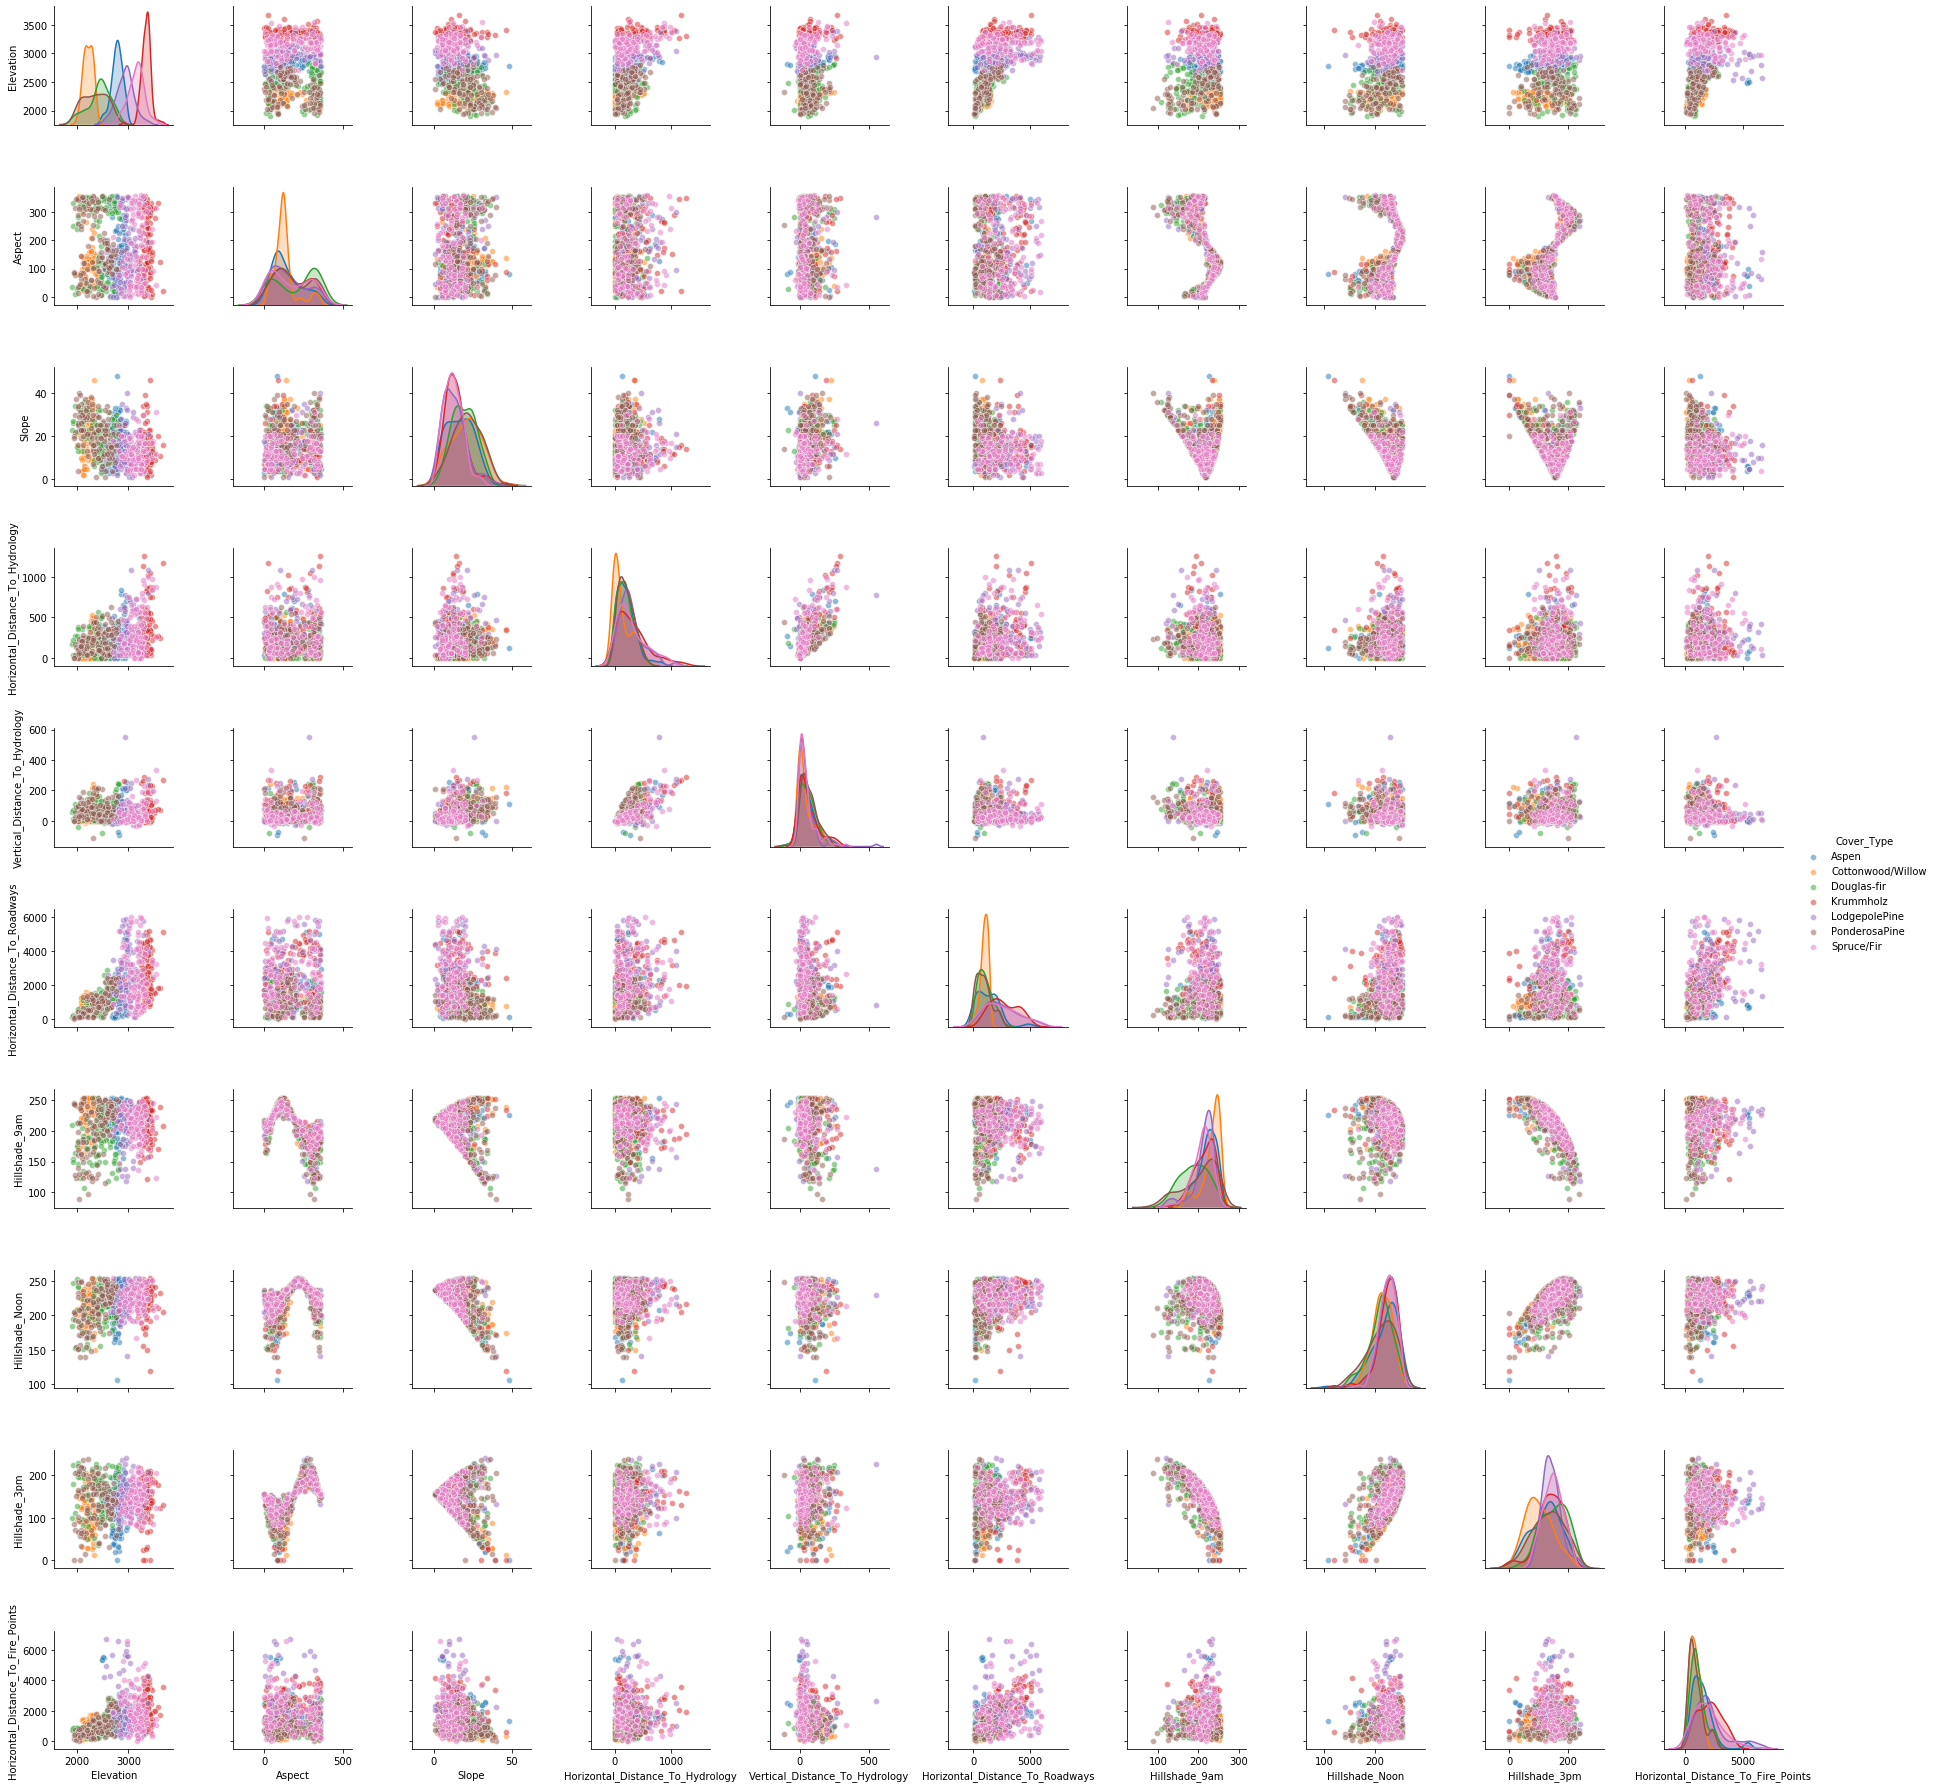

In [306]:
# only use non-one-hot-encoded variables
cols_no_binary = [c for c in colnames if c not in soiltypes + wilderness]

# split variables into chunks for better plotting
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

df_joined = pd.concat([df_train, df_valid])

sns.color_palette("colorblind", 7)
sns.pairplot(df_joined[cols_no_binary].sample(frac=.05, random_state=42), 
             hue='Cover_Type', plot_kws={'alpha': .5}) #, vars=cols_no_binary[:-1])

In [313]:
# the same ting but interactive!
import hvplot.pandas
hvplot.scatter_matrix(df_joined[cols_no_binary].sample(frac=.05, random_state=42), c="Cover_Type", alpha=.5, diagonal='kde')


:GridMatrix   [X,Y]
   :NdOverlay   [Cover_Type]
      :Distribution   [Vertical_Distance_To_Hydrology]   (Density)

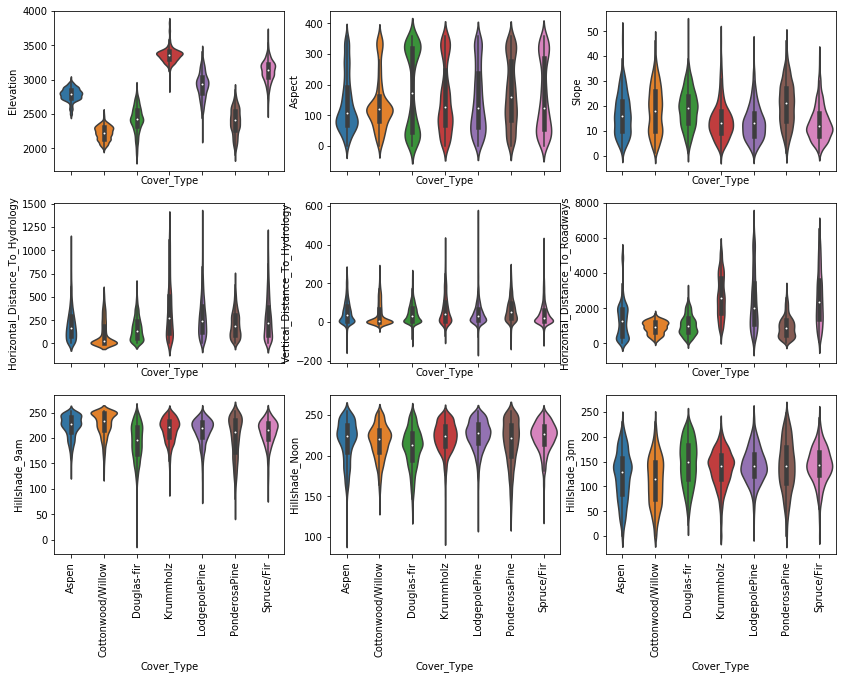

In [307]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 3, sharex=True, figsize=(14,10))

for i, ax in enumerate(axes.flat):
    sns.violinplot(data=df_joined, x='Cover_Type', y=cols_no_binary[i], ax=ax)  

    for t in ax.get_xticklabels():
        t.set_rotation(90)

## Looking at one-hot encoded features
For easier handling we transform them back from their original one-hot encoding into categorical columns...

In [308]:
df_joined['wilderness'] = (df.loc[:, wilderness] == 1).idxmax(1)
df_joined['soiltype'] = (df.loc[:, soiltypes] == 1).idxmax(1)
df_joined.drop(wilderness + soiltypes, axis=1, inplace=True)
df_joined.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,wilderness,soiltype
0,2596,51,3,258,0,510,221,232,148,6279,Aspen,Wilderness_Area1,Soil_Type29
1,2590,56,2,212,-6,390,220,235,151,6225,Aspen,Wilderness_Area1,Soil_Type29
2,2804,139,9,268,65,3180,234,238,135,6121,LodgepolePine,Wilderness_Area1,Soil_Type12
3,2785,155,18,242,118,3090,238,238,122,6211,LodgepolePine,Wilderness_Area1,Soil_Type30
4,2595,45,2,153,-1,391,220,234,150,6172,Aspen,Wilderness_Area1,Soil_Type29


In [309]:
df_joined['soiltype'] = df_joined.soiltype.astype('category').cat.as_ordered()
df_joined['wilderness'] = df_joined.wilderness.astype('category').cat.as_ordered()
df_joined.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,wilderness,soiltype
0,2596,51,3,258,0,510,221,232,148,6279,Aspen,Wilderness_Area1,Soil_Type29
1,2590,56,2,212,-6,390,220,235,151,6225,Aspen,Wilderness_Area1,Soil_Type29
2,2804,139,9,268,65,3180,234,238,135,6121,LodgepolePine,Wilderness_Area1,Soil_Type12
3,2785,155,18,242,118,3090,238,238,122,6211,LodgepolePine,Wilderness_Area1,Soil_Type30
4,2595,45,2,153,-1,391,220,234,150,6172,Aspen,Wilderness_Area1,Soil_Type29


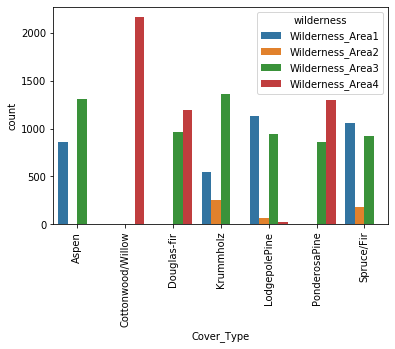

In [310]:
g = sns.countplot(data=df_joined, x='Cover_Type', hue='wilderness')
g.set_xticklabels(g.get_xticklabels(), rotation=90);

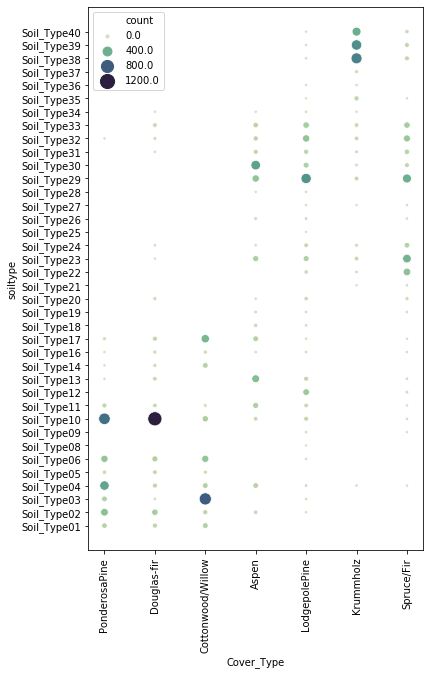

In [311]:
df_grp = df_joined.groupby(['Cover_Type','soiltype']).size().unstack(0).fillna(0)

df_melted = pd.melt(df_grp.rename(columns=str).reset_index(), id_vars=['soiltype'])
df_melted.rename({'value': 'count'}, axis=1, inplace=True)
df_melted = df_melted[df_melted['count'] > 0]
df_melted.sort_values(by=['soiltype'], inplace=True)

plt.figure(figsize=(6,10))
cmap = sns.cubehelix_palette(4, start=.5, rot=-.75, as_cmap=True) #rot=-.2, as_cmap=True)

import numpy as np
g = sns.scatterplot(data=df_melted, x='Cover_Type', y='soiltype', size='count', hue='count', legend='brief', sizes=(10,200), palette=cmap)
plt.xticks(rotation=90);